#Ising Model PCA


Wang 2016 "*Discovering Phase Transitions with Unsupervised Learning*" [[1]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.94.195105)

##Libraries

In [2]:
#basic libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

#machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

#removing warnings
import warnings
warnings.filterwarnings("ignore")

#plot in jupyter notebook
%matplotlib inline

#when using colab I like to do this to access the files in drive
#if running in a local pc: 
#           comment this cell
#           change the files' path
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##Save Images

In [3]:
#save = 0           # save figs
save = 1            # don't save figs

## Functions

In [54]:
###### FUNCTIONS ######

#With a matrix X return the pca model, eigenvalues and eigenvectors
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
def get_pca(samples, N):
  pca = PCA(n_components=N)

  saux = samples.drop('TEMP', axis = 1)
  saux = saux.drop('M', axis = 1)
  saux = saux.drop('E', axis = 1)

  pca.fit(saux)
  evals = pca.explained_variance_ratio_
  evecs = pca.components_

  return evals, evecs, pca

#Returns the projection of matrix X in the eigenvectors of the pca model
def get_pca_results(samples, pca):
  saux = samples.drop('TEMP', axis = 1)
  saux = saux.drop('M', axis = 1)
  saux = saux.drop('E', axis = 1)
  
  pca_result = pca.transform(saux)
  pca_result = pd.DataFrame(pca_result, columns = ['C'+str(i) for i in range(0,N)])
  pca_result['TEMP'] = samples['TEMP']

  return pca_result

#Getting cluster with Spectral Clustering
def get_spectral(A, B, C):
  clusters = list(zip(C0, C1))
  clusters = np.array(clusters)
  pd.DataFrame(clusters, columns=['C0','C1'])
  clusters = StandardScaler().fit_transform(clusters)
  clustering = SpectralClustering(n_clusters=C,assign_labels='discretize',random_state=0).fit(clusters)

  return clustering.labels_

#Getting cluster with DBSCAN
def get_dbscan(A, B, EPS, MINSAMPLES):
  clusters = list(zip(A, B))
  clusters = np.array(clusters)
  pd.DataFrame(clusters, columns=['C0','C1'])
  clusters = StandardScaler().fit_transform(clusters)

  db = DBSCAN(eps=EPS, min_samples=MINSAMPLES).fit(clusters)
  clusters_labels = db.labels_

  n_clusters_ = len(set(clusters_labels)) - (1 if -1 in clusters_labels else 0)
  n_noise_ = list(clusters_labels).count(-1)

  return clusters_labels, n_clusters_, n_noise_

###### PLOT FUNCTIONS ######

#Plot the eigenvalues
def plot_evals(e1, e2, e3, filename):
  x_ax = np.arange(1, len(e1)+1, 1, dtype = 'int')
  
  fig, ax = plt.subplots(figsize=(12, 8))
  
  plt.plot(x_ax, e1, '-o', label='L20')
  plt.plot(x_ax, e2, '-o', label='L40')
  plt.plot(x_ax, e3, '-o', label='L80')

  plt.xlabel('$l$')
  plt.xticks(np.arange(1, 11, step=1))
  plt.ylabel('$\lambda_l$')
  plt.yscale("log")

  plt.legend(loc='best')
  plt.title("Principal Components")
  
  if (save==0):
    plt.savefig(filename)

  plt.show()

#Plot pca projections. 
#for more cmaps https://matplotlib.org/stable/tutorials/colors/colormaps.html
def plot_pca_components(A1, B1, T1, A2, B2, T2, A3, B3, T3, filename):
  #color func
  my_cmap = plt.get_cmap("rainbow")
  rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    
  fig, axs = plt.subplots(3, figsize=(12,8))

  axs[0].scatter(A1, B1, color=my_cmap(rescale(T1)), edgecolor='black')
  axs[1].scatter(A2, B2, color=my_cmap(rescale(T2)), edgecolor='black')
  axs[2].scatter(A3, B3, color=my_cmap(rescale(T3)), edgecolor='black')

  for ax in axs.flat:
    ax.set_ylabel(r'$\lambda_2$')
    ax.set_xlim([np.min(A3)-10, np.max(A3)+10])
    ax.set_ylim([np.min(B3)-10, np.max(B3)+10])

  axs[0].set_xticks([])
  axs[1].set_xticks([])
  axs[0].set_xticklabels([])
  axs[1].set_xticklabels([])

  axs[2].set_xlabel(r'$\lambda_1$')

  plt.subplots_adjust(hspace=0.1)

  norm = Normalize(vmin=np.min(T1), vmax=np.max(T1)) 
  scalarMap = cm.ScalarMappable(norm=norm, cmap=my_cmap)
  fig.colorbar(scalarMap, ax=fig.get_axes())
  
  fig.suptitle("Principal Components Projections", x=0.45, y=.93)
  
  if (save==0):
    plt.savefig(filename)
  
  plt.show()

#Plot clusters
def plot_clusters(A, B, clusters_labels, filename):
  fig, axs = plt.subplots(figsize=(12,8))
  
  my_cmap = plt.get_cmap("rainbow")
  rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

  plt.scatter(A, B, color=my_cmap(rescale(clusters_labels)), edgecolor='black')

  plt.ylabel(r'$\lambda_2$')
  plt.xlabel(r'$\lambda_1$')
    
  plt.xlim([np.min(A)-10, np.max(A)+10])
  plt.ylim([np.min(B)-10, np.max(B)+10])
  
  plt.title("Clusters of PCA Projections")
  
  if (save==0):
    plt.savefig(filename)

  plt.show()

#Plot temp series
def plot_ts(A, B, ylabel, filename):
  fig, axs = plt.subplots(figsize=(12,8))
  
  min = np.min(B) - 1000
  max = np.max(B) + 1000

  plt.ylim(min, max)

  plt.scatter(A, B, label=ylabel, edgecolor='black')
  plt.vlines(2.269, ymin=min, ymax=max, color='black')

  plt.xlabel('Temp')
  plt.ylabel(ylabel)
  
  plt.legend(loc='best')
  plt.title("Temporal Series of " + ylabel)

  if (save==0):
    plt.savefig(filename)

  plt.show()

#Plot temp series with cluster label colors
def plot_ts_clusters(A, B, clusters_labels, ylabel, filename):
  fig, axs = plt.subplots(figsize=(12,8))
  
  min = np.min(B) - 1000
  max = np.max(B) + 1000

  plt.ylim(min, max)

  my_cmap = plt.get_cmap("rainbow")
  rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

  plt.scatter(A, B, color=my_cmap(rescale(clusters_labels)), edgecolor='black', label=ylabel)
  plt.vlines(2.269, ymin=min, ymax=max, color='black')

  plt.xlabel('Temp')
  plt.ylabel(ylabel)
  
  plt.legend(loc='best')
  plt.title("Temporal series of " + ylabel)

  if (save==0):
    plt.savefig(filename)

  plt.show()

## Data

### Reading


In [36]:
#definitions
L20 = 20      #LSIZE
data_path20 = "/content/gdrive/Shareddrives/IA - Física/Pedro Mendes/wang2016/ising/df20.csv"
L40 = 40      #LSIZE
data_path40 = "/content/gdrive/Shareddrives/IA - Física/Pedro Mendes/wang2016/ising/df40.csv"
L80 = 80      #LSIZE
data_path80 = "/content/gdrive/Shareddrives/IA - Física/Pedro Mendes/wang2016/ising/df80.csv"

#reading and dropping first column
ising_samples20 = pd.read_csv(data_path20)
ising_samples20 = ising_samples20.drop(ising_samples20.columns[[0]], axis = 1)

ising_samples40 = pd.read_csv(data_path40)
ising_samples40 = ising_samples40.drop(ising_samples40.columns[[0]], axis = 1)

ising_samples80 = pd.read_csv(data_path80)
ising_samples80 = ising_samples80.drop(ising_samples80.columns[[0]], axis = 1)

###Plots for L80

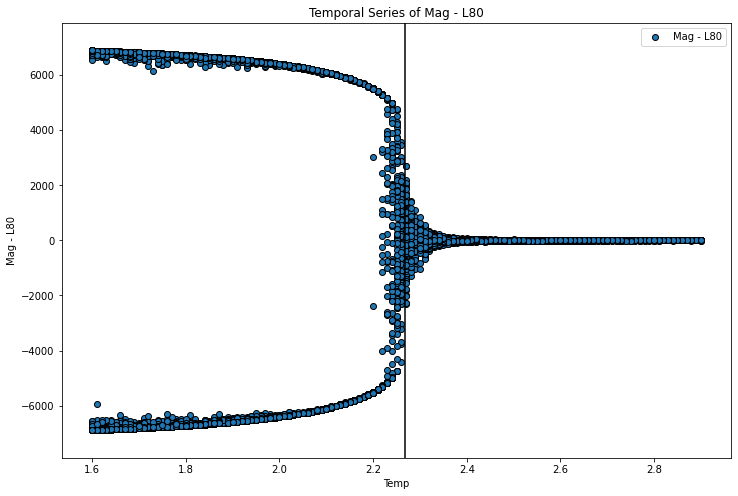

In [37]:
#mag temp series
plot_ts(ising_samples80['TEMP'], ising_samples80['M'], 'Mag - L80', 'ising_mag.png')

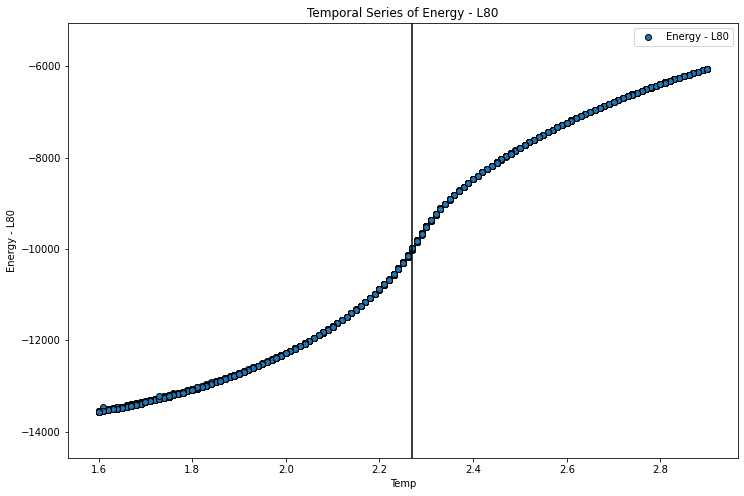

In [38]:
#ene temp series
plot_ts(ising_samples80['TEMP'], ising_samples80['E'], 'Energy - L80', 'ising_Ene.png')

## PCA

### PCA decomposition

In [39]:
#Number of components
N = 10 

#PCA calculation
evals20, evecs20, pca20 = get_pca(ising_samples20, N)
evals40, evecs40, pca40 = get_pca(ising_samples40, N)
evals80, evecs80, pca80 = get_pca(ising_samples80, N)

#Get the projections
pca_r_20 = get_pca_results(ising_samples20, pca20)
pca_r_40 = get_pca_results(ising_samples40, pca40)
pca_r_80 = get_pca_results(ising_samples80, pca80)

###PCA Plots

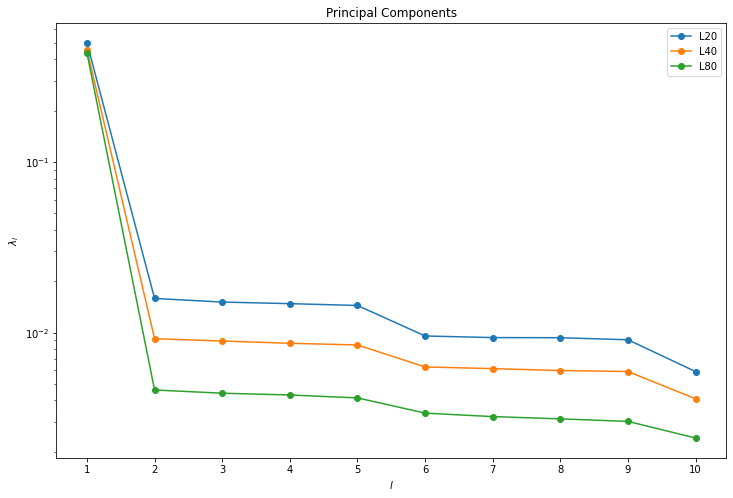

In [40]:
#PCA eigenvalues plot, Y axis in log scale
plot_evals(evals20, evals40, evals80, 'ising_pca_multi_evals_2.png')

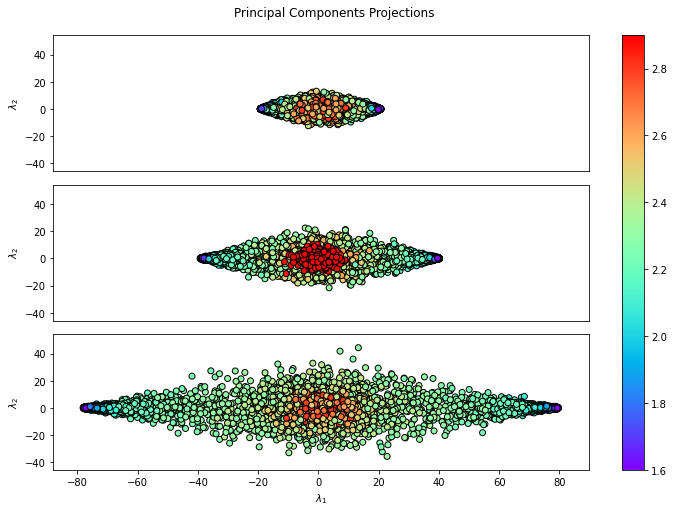

In [41]:
#Plotting the projections
plot_pca_components(pca_r_20['C0'], pca_r_20['C1'], pca_r_20['TEMP'], 
                    pca_r_40['C0'], pca_r_40['C1'], pca_r_40['TEMP'], 
                    pca_r_80['C0'], pca_r_80['C1'], pca_r_80['TEMP'], 
                    'ising_pca_components_2.png')

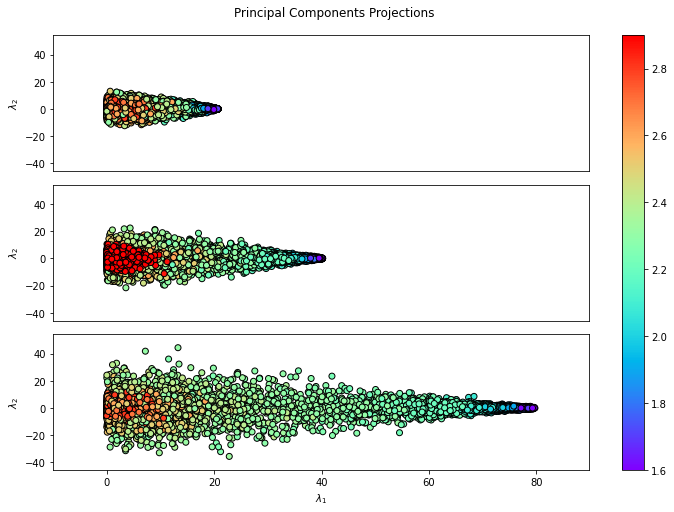

In [55]:
plot_pca_components(np.abs(pca_r_20['C0']), pca_r_20['C1'], pca_r_20['TEMP'], 
                    np.abs(pca_r_40['C0']), pca_r_40['C1'], pca_r_40['TEMP'], 
                    np.abs(pca_r_80['C0']), pca_r_80['C1'], pca_r_80['TEMP'], 
                    'ising_pca_m_components.png')

Temp series

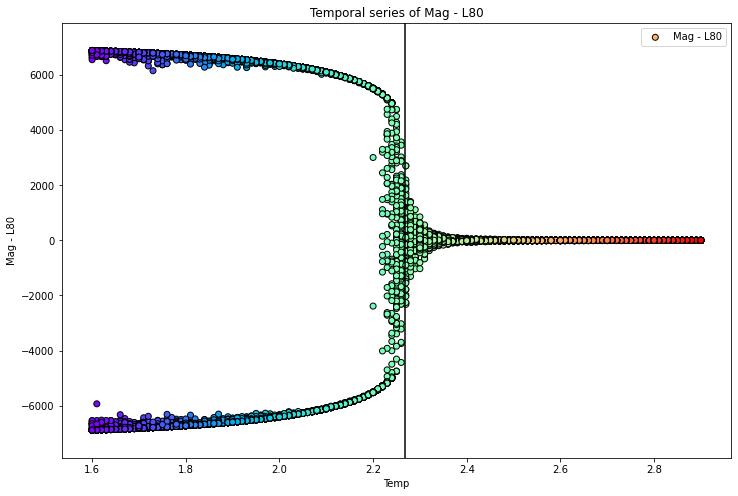

In [56]:
#mag temp series label as clusters
plot_ts_clusters(ising_samples80['TEMP'], ising_samples80['M'],
                 pca_r_80['TEMP'], 'Mag - L80', 'ising80_mag_pca_colors_L80.png')

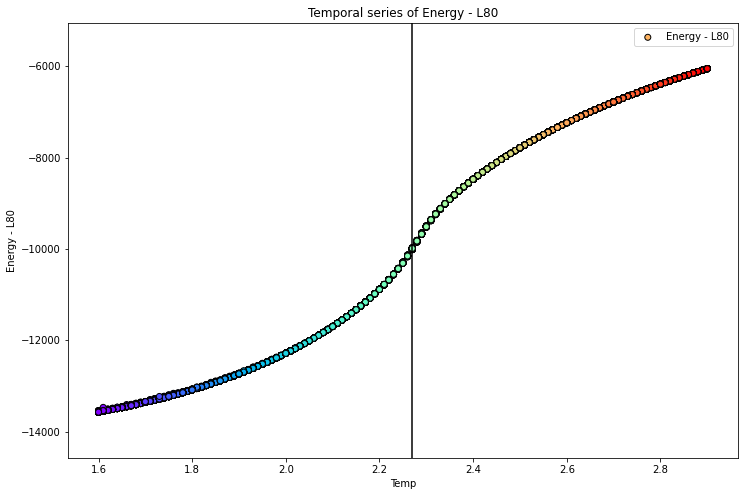

In [57]:
#ene temp series label as clusters
plot_ts_clusters(ising_samples80['TEMP'], ising_samples80['E'],
                 pca_r_80['TEMP'], 'Energy - L80', 'ising80_ene_pca_colors_L80.png')

## Clusterization L80



In [45]:
#Defs for Clusterization
C0 = np.abs(pca_r_80['C0'])
C1 = pca_r_80['C1']

#spectral cluster need Number of Clusters
Nc = 2

### Spectral Clustering

In [46]:
#spectral clustering labels for N clusters
spc_lb = get_spectral(C0, C1, Nc)

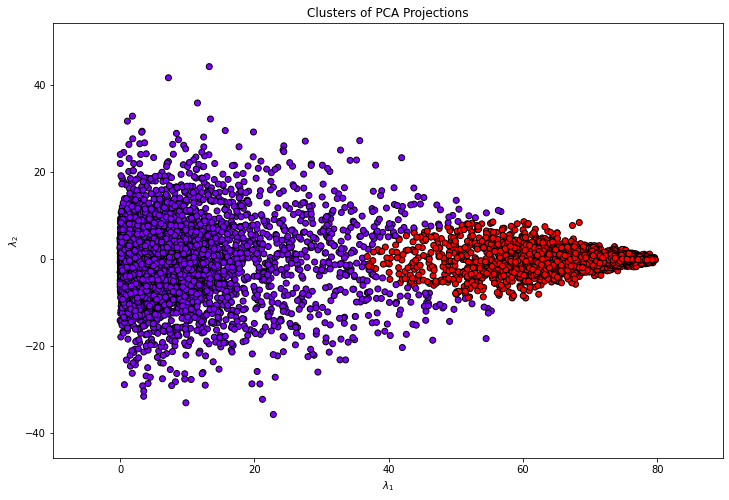

In [47]:
#plot clusters
plot_clusters(C0, C1, spc_lb, 'ising_clusters_sp_L80.png')

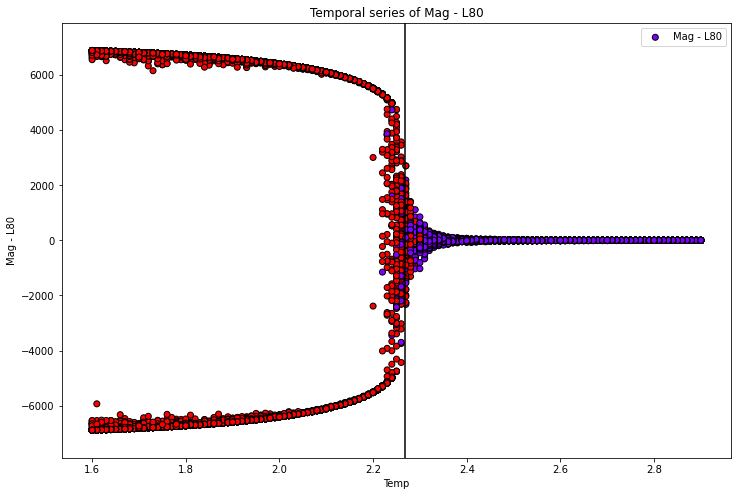

In [58]:
#mag temp series label as clusters
plot_ts_clusters(ising_samples80['TEMP'],ising_samples80['M'],
                 spc_lb, 'Mag - L80', 'ising80_mag_sp_cluster_L80.png')

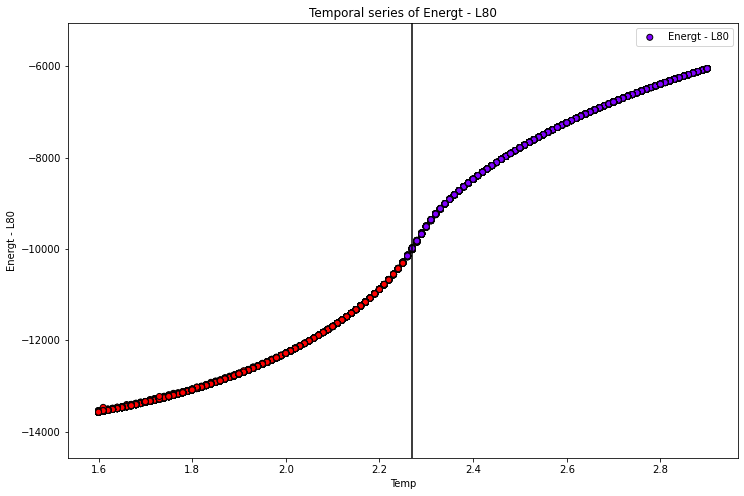

In [59]:
#ene temp series label as clusters
plot_ts_clusters(ising_samples80['TEMP'], ising_samples80['E'],
                 spc_lb, 'Energt - L80', 'ising80_ene_sp_cluster_L80.png')

###DBSCAN


In [50]:
#Passing DBSCAN
dbc_lb, dbc_nc, dbc_nn = get_dbscan(C0, C1, 0.3, 65)

#number of clusters
print("Number of clusters:", dbc_nc)

#number of noise
print("Number of noise points:", dbc_nn)

Number of clusters: 2
Number of noise points: 546


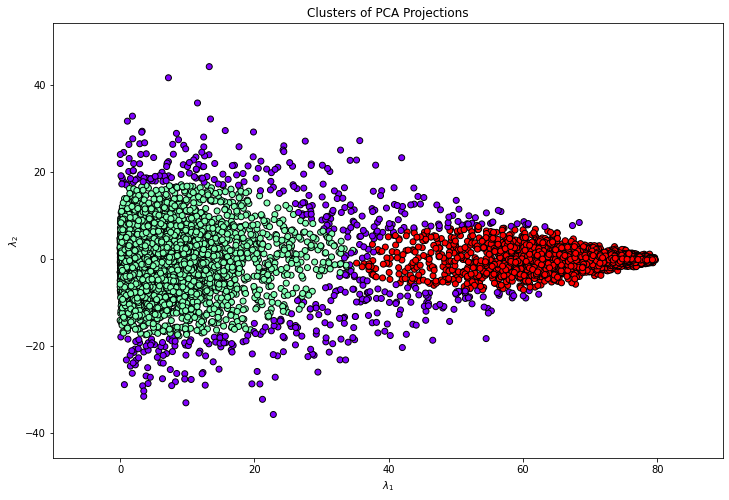

In [51]:
#ploting clusters and noise
plot_clusters(C0, C1, dbc_lb, 'ising_clusters_db_L80.png')

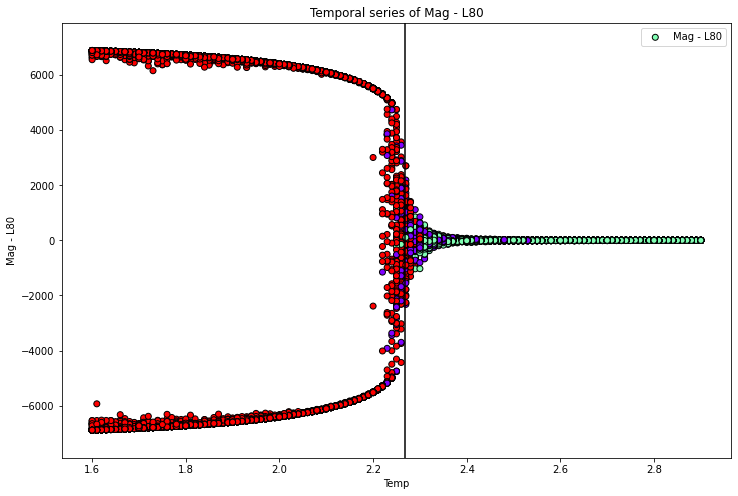

In [60]:
#mag temp series label as clusters
plot_ts_clusters(ising_samples80['TEMP'], ising_samples80['M'],
                 dbc_lb, 'Mag - L80', 'ising80_mag_db_cluster.png')

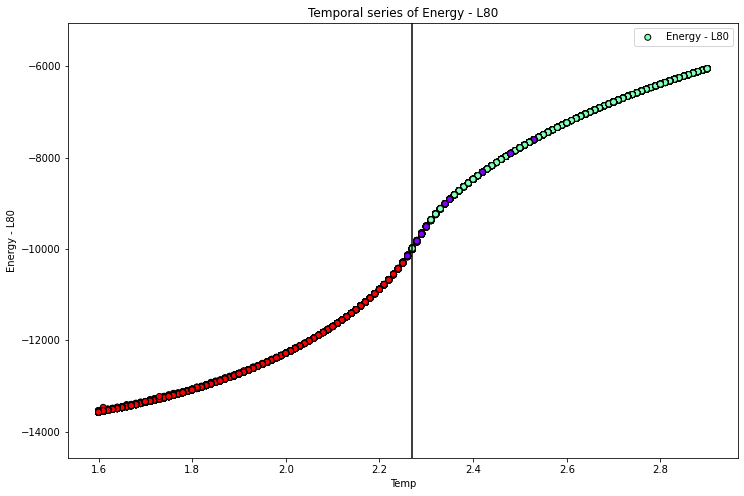

In [61]:
#ene temp series label as clusters
plot_ts_clusters(ising_samples80['TEMP'], ising_samples80['E'],
                 dbc_lb, 'Energy - L80', 'ising80_ene_db_cluster_L80.png')